# Basic model with static forcing

In [3]:
# | include: false
import os

os.environ["USE_PYGEOS"] = "0"

In [4]:
import geopandas as gpd
import numpy as np
import pandas as pd
from pathlib import Path

import ribasim

Set up the nodes:

In [5]:
xy = np.array(
    [
        (0.0, 0.0),  # 1: Basin,
        (1.0, 0.0),  # 2: ManningResistance
        (2.0, 0.0),  # 3: Basin
        (3.0, 0.0),  # 4: TabulatedRatingCurve
        (3.0, 1.0),  # 5: FractionalFlow
        (3.0, 2.0),  # 6: Basin
        (4.0, 1.0),  # 7: Pump
        (4.0, 0.0),  # 8: FractionalFlow
        (5.0, 0.0),  # 9: Basin
        (6.0, 0.0),  # 10: LevelControl
        (2.0, 2.0),  # 11: LevelBoundary
        (2.0, 1.0),  # 12: LinearResistance
        (3.0, -1.0),  # 13: FractionalFlow
        (3.0, -2.0),  # 14: Terminal
        (3.0, 3.0),  # 15: Flowboundary
    ]
)
node_xy = gpd.points_from_xy(x=xy[:, 0], y=xy[:, 1])

node_type = [
    "Basin",
    "ManningResistance",
    "Basin",
    "TabulatedRatingCurve",
    "FractionalFlow",
    "Basin",
    "Pump",
    "FractionalFlow",
    "Basin",
    "LevelControl",
    "LevelBoundary",
    "LinearResistance",
    "FractionalFlow",
    "Terminal",
    "FlowBoundary",
]

# Make sure the feature id starts at 1: explicitly give an index.
node = ribasim.Node(
    static=gpd.GeoDataFrame(
        data={"type": node_type},
        index=pd.Index(np.arange(len(xy)) + 1, name="fid"),
        geometry=node_xy,
        crs="EPSG:28992",
    )
)

Setup the edges:

In [6]:
from_id = np.array([1, 2, 3, 4, 4, 5, 6, 8, 7, 9, 11, 12, 4, 13, 15], dtype=np.int64)
to_id = np.array([2, 3, 4, 5, 8, 6, 7, 9, 9, 10, 12, 3, 13, 14, 6], dtype=np.int64)
lines = ribasim.utils.geometry_from_connectivity(node, from_id, to_id)
edge = ribasim.Edge(
    static=gpd.GeoDataFrame(
        data={"from_node_id": from_id, "to_node_id": to_id},
        geometry=lines,
        crs="EPSG:28992",
    )
)

Setup the basins:

In [7]:
profile = pd.DataFrame(
    data={
        "node_id": [1, 1, 3, 3, 6, 6, 9, 9],
        "storage": [0.0, 1000.0] * 4,
        "area": [0.0, 1000.0] * 4,
        "level": [0.0, 1.0] * 4,
    }
)

# Convert steady forcing to m/s
# 2 mm/d precipitation, 1 mm/d evaporation
seconds_in_day = 24 * 3600
precipitation = 0.002 / seconds_in_day
evaporation = 0.001 / seconds_in_day

static = pd.DataFrame(
    data={
        "node_id": [0],
        "drainage": [0.0],
        "potential_evaporation": [evaporation],
        "infiltration": [0.0],
        "precipitation": [precipitation],
        "urban_runoff": [0.0],
    }
)
static = static.iloc[[0, 0, 0, 0]]
static["node_id"] = [1, 3, 6, 9]

basin = ribasim.Basin(profile=profile, static=static)

Setup linear resistance:

In [8]:
linear_resistance = ribasim.LinearResistance(
    static=pd.DataFrame(data={"node_id": [12], "resistance": [5e3]})
)

Setup Manning resistance:

In [9]:
manning_resistance = ribasim.ManningResistance(
    static=pd.DataFrame(
        data={
            "node_id": [2],
            "length": [900.0],
            "manning_n": [0.04],
            "profile_width": [6.0],
            "profile_slope": [3.0],
        }
    )
)

Set up a rating curve node:

In [10]:
# Discharge: lose 1% of storage volume per day at storage = 1000.0.
q1000 = 1000.0 * 0.01 / seconds_in_day

rating_curve = ribasim.TabulatedRatingCurve(
    static=pd.DataFrame(
        data={
            "node_id": [4, 4],
            "level": [0.0, 1.0],
            "discharge": [0.0, q1000],
        }
    )
)

Setup fractional flows:

In [11]:
fractional_flow = ribasim.FractionalFlow(
    static=pd.DataFrame(
        data={
            "node_id": [5, 8],
            "fraction": [0.3, 0.7],
        }
    )
)

Setup level control:

In [12]:
level_control = ribasim.LevelControl(
    static=pd.DataFrame(
        data={
            "node_id": [10],
            "target_level": [1.5],
            "resistance": [(3600.0 * 24) / 100.0],
        }
    )
)

Setup pump:

In [13]:
pump = ribasim.Pump(
    static=pd.DataFrame(
        data={
            "node_id": [7],
            "flow_rate": [0.5 / 3600],
        }
    )
)

Setup level boundary:

In [14]:
level_boundary = ribasim.LevelBoundary(
    static=pd.DataFrame(
        data={
            "node_id": [11],
            "level": [0.5],
        }
    )
)

Setup flow boundary:

In [17]:
flow_boundary = ribasim.FlowBoundary(
    static=pd.DataFrame(
        data={
            "node_id": [15],
            "flow_rate": [0.5 / 3600],
        }
    )
)

Setup a model:

In [18]:
model = ribasim.Model(
    modelname="basic",
    node=node,
    edge=edge,
    basin=basin,
    level_boundary=level_boundary,
    flow_boundary=flow_boundary,
    level_control=level_control,
    pump=pump,
    linear_resistance=linear_resistance,
    manning_resistance=manning_resistance,
    tabulated_rating_curve=rating_curve,
    fractional_flow=fractional_flow,
    starttime="2020-01-01 00:00:00",
    endtime="2021-01-01 00:00:00",
)

Let's take a look at the model:

<Axes: >

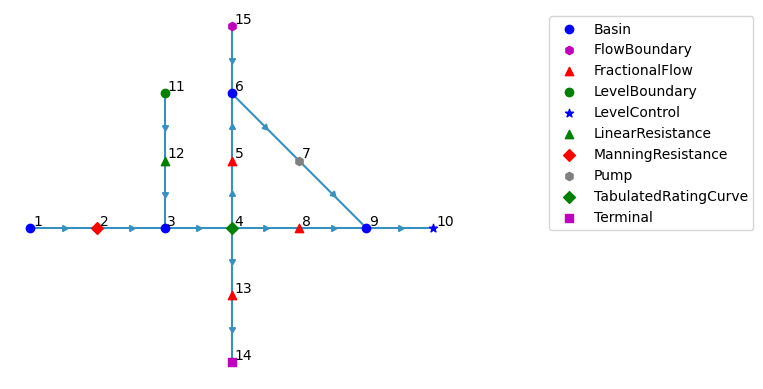

In [32]:
model.plot(legend=True)

Write the model to a TOML and GeoPackage:

In [20]:
datadir = Path("data")
model.write(datadir / "basic")

# Update the basic model with transient forcing

This assumes you have already created the basic model with static forcing.

In [21]:
import numpy as np
import pandas as pd
import xarray as xr

import ribasim

In [22]:
model = ribasim.Model.from_toml(datadir / "basic/basic.toml")

In [23]:
time = pd.date_range(model.starttime, model.endtime)
day_of_year = time.day_of_year.to_numpy()
seconds_per_day = 24 * 60 * 60
evaporation = (
    (-1.0 * np.cos(day_of_year / 365.0 * 2 * np.pi) + 1.0) * 0.0025 / seconds_per_day
)
rng = np.random.default_rng(seed=0)
precipitation = (
    rng.lognormal(mean=-1.0, sigma=1.7, size=time.size) * 0.001 / seconds_per_day
)

We'll use xarray to easily broadcast the values.

In [24]:
timeseries = (
    pd.DataFrame(
        data={
            "node_id": 1,
            "time": time,
            "drainage": 0.0,
            "potential_evaporation": evaporation,
            "infiltration": 0.0,
            "precipitation": precipitation,
            "urban_runoff": 0.0,
        }
    )
    .set_index("time")
    .to_xarray()
)

basin_ids = model.basin.static["node_id"].to_numpy()
basin_nodes = xr.DataArray(
    np.ones(len(basin_ids)), coords={"node_id": basin_ids}, dims=["node_id"]
)
forcing = (timeseries * basin_nodes).to_dataframe().reset_index()

In [25]:
state = pd.DataFrame(
    data={
        "node_id": basin_ids,
        "storage": 1000.0,
        "concentration": 0.0,
    }
)

In [26]:
model.basin.forcing = forcing
model.basin.state = state

In [27]:
model.modelname = "basic-transient"
model.write(datadir / "basic-transient")

In [29]:
# | include: false
from subprocess import run

run(
    [
        "julia",
        "--project=../../core",
        "--eval",
        f'using Ribasim; Ribasim.run("{datadir.as_posix()}/basic-transient/basic-transient.toml")',
    ],
    check=True,
)

CompletedProcess(args=['julia', '--project=../../core', '--eval', 'using Ribasim; Ribasim.run("data/basic-transient/basic-transient.toml")'], returncode=0)

Now run the model with `ribasim basic-transient/basic.toml`.
After running the model, read back the output:

<Axes: xlabel='time'>

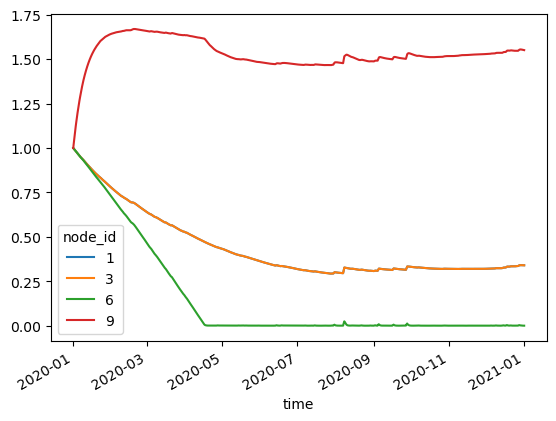

In [30]:
df_basin = pd.read_feather(datadir / "basic-transient/output/basin.arrow")
df_basin_wide = df_basin.pivot_table(
    index="time", columns="node_id", values=["storage", "level"]
)
df_basin_wide["level"].plot()

<Axes: xlabel='time'>

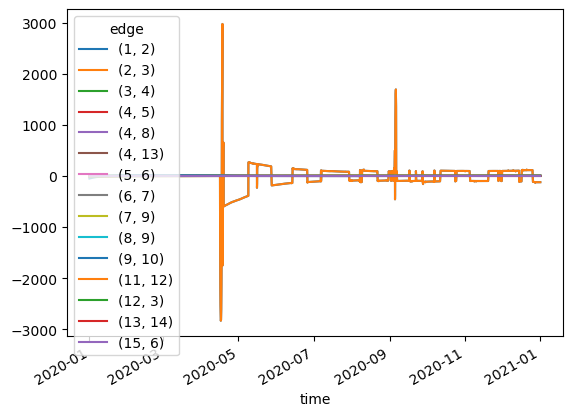

In [31]:
df_flow = pd.read_feather(datadir / "basic-transient/output/flow.arrow")
df_flow["edge"] = list(zip(df_flow.from_node_id, df_flow.to_node_id))
df_flow["flow_m3d"] = df_flow.flow * 86400
df_flow.pivot_table(index="time", columns="edge", values="flow_m3d").plot()